# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 


**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.**

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


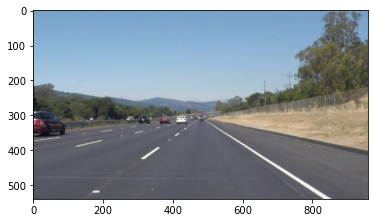

In [33]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')


## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [34]:
import math

def grayscale(img):
    """
    This will return an image with only one color channel
    NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')
    otherwise it show up greenish 
    """
    
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank black mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color, red
    #output black canvas with red polygon
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    #output black canvas with polygon shape picture 
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):

    #for line in lines:
        #for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)

    x_left_lane = []
    y_left_lane = []
    x_right_lane = []
    y_right_lane = []
    ytop = int(350) # need y coordinates of the top and bottom of left and right lane
    ybtm = int(540) #  to calculate x values once a line is found
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = float(((y2-y1)/(x2-x1)))
            if (slope > 0.3): # if the line slope is greater than 0, it is the left lane
                    x_left_lane.append(x1)
                    x_left_lane.append(x2)
                    y_left_lane.append(y1)
                    y_left_lane.append(y2)
                    
            if (slope < -0.3): # if the line slope is less than 0, it is the right lane
                    x_right_lane.append(x1)
                    x_right_lane.append(x2)
                    y_right_lane.append(y1)
                    y_right_lane.append(y2)
                    
    
    # only execute if there are points found that meet criteria
    if (x_left_lane!=[]) & (x_right_lane!=[]) & (y_left_lane!=[]) & (y_right_lane!=[]): 
        left_line_coeffs = (np.polyfit(x_left_lane, y_left_lane, 1))
        left_xtop = int((ytop - left_line_coeffs[1])/left_line_coeffs[0])
        left_xbtm = int((ybtm - left_line_coeffs[1])/left_line_coeffs[0])
        
        #draw a line on the picture 
        cv2.line(img, (left_xtop, ytop), (left_xbtm, ybtm), color, thickness)
        
        right_line_coeffs = np.polyfit(x_right_lane, y_right_lane, 1)
        right_xtop = int((ytop - right_line_coeffs[1])/right_line_coeffs[0])
        right_xbtm = int((ybtm - right_line_coeffs[1])/right_line_coeffs[0])
       
        cv2.line(img, (right_xtop, ytop), (right_xbtm, ybtm), color, thickness)

        
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an black canvas with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines()
    `initial_img` is the image before any processing.
    
    The result image is computed as follows:  
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    
    #layer the picture 
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [41]:
import os
test_images_list = os.listdir("test_images_output/") # modified a little to save filenames of test images
print(test_images_list)


['solidYellowCurve.jpg', 'solidYellowLeft.jpg', 'solidYellowCurve2.jpg', 'solidWhiteRight.jpg', 'whiteCarLaneSwitch.jpg', 'solidWhiteCurve.jpg']


## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

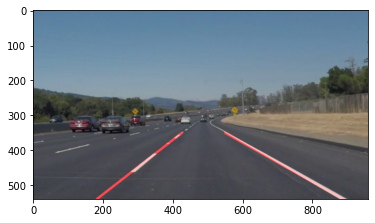

In [42]:
# Building a pipeline that will draw lane lines on the test_images
for test_image in test_images_list: # iterating through the images in test_images folder
    
    #CONVERT THE IMAGE FROM RGB TO HSL COLORSPACE
    #for test_image in test_images_list: # iterating through the images in test_images folder
    image = mpimg.imread('test_images/' + test_image) # reading in an image
    
    '''this step is for preprocessing there are different modes to choose, gray, hsv, hsl
       or you can skip this step too'''
    #hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # HSV conversion
    #grap = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) #Gray conversion 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) # HSL conversion
    

    #APPLY A GAUSSIAN FILTER FOR SMOOTHING OF LANE LINES
    # Define a kernel size for Gaussian smoothing / blurring 
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 3
    blur_hls = cv2.GaussianBlur(hls,(kernel_size, kernel_size), 0)

    # DEFINE PARAMETERS FOR CANNY EDGE DETECTOR / RATIO OF 1:3 FOR LOW TO HIGH THRESHOLD
    low_threshold = 50
    high_threshold = 150
    
    # black canvas with dotted outliner 
    edges = cv2.Canny(blur_hls, low_threshold, high_threshold)
    imshape = edges.shape

    # CREATE A MASKED IMAGE OF OUR CANNY FILTER OUTPUT IMAGE'edges' 
    vertices = np.array([[(0,imshape[0]),(390, 350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)

    # DEFINE PARAMETERS FOR HOUGH TRANSFORM
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 # minimum number of pixels making up a line
    max_line_gap = 25   # maximum gap in pixels between connectable line segments

    # Utilize output of Hough Transform and return a masked image 'line_image' with red Hough Lines drawn
    masked_edges = region_of_interest(edges, vertices) # retain information only in the region of interest
    line_image = hough_lines(masked_edges, rho, theta, threshold,\
                                 min_line_length, max_line_gap)

    # CREATE A "COLOR" IMAGE COMBINNG THE ORIGNAL IMAGE WITH THE PROCESSED IMAGE 'line_image'
    final_img = weighted_img(line_image, image, α=0.8, β=1.)

    #Display the image
    plt.imshow(final_img)

    # then save them to the test_images_output directory.
    mpimg.imsave('test_images_output/' + test_image, final_img) # save the resulting image

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
def process_image(image):
    '''this step is for preprocessing there are different modes to choose, gray, hsv, hsl
       or you can skip this step too'''
    #hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV) # HSV conversion
    #grap = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY) #Gray conversion 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS) # HSL conversion
    

    #APPLY A GAUSSIAN FILTER FOR SMOOTHING OF LANE LINES
    # Define a kernel size for Gaussian smoothing / blurring 
    # Note: this step is optional as cv2.Canny() applies a 5x5 Gaussian internally
    kernel_size = 3
    blur_hls = cv2.GaussianBlur(hls,(kernel_size, kernel_size), 0)

    # DEFINE PARAMETERS FOR CANNY EDGE DETECTOR / RATIO OF 1:3 FOR LOW TO HIGH THRESHOLD
    low_threshold = 50
    high_threshold = 150
    
    # black canvas with dotted outliner 
    edges = cv2.Canny(blur_hls, low_threshold, high_threshold)
    imshape = edges.shape

    # CREATE A MASKED IMAGE OF OUR CANNY FILTER OUTPUT IMAGE'edges' 
    vertices = np.array([[(0,imshape[0]),(390, 350), (580,350), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges,vertices)

    # DEFINE PARAMETERS FOR HOUGH TRANSFORM
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20 # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 15 # minimum number of pixels making up a line
    max_line_gap = 25   # maximum gap in pixels between connectable line segments

    # Utilize output of Hough Transform and return a masked image 'line_image' with red Hough Lines drawn
    masked_edges = region_of_interest(edges, vertices) # retain information only in the region of interest
    line_image = hough_lines(masked_edges, rho, theta, threshold,\
                                 min_line_length, max_line_gap)

    # CREATE A "COLOR" IMAGE COMBINNG THE ORIGNAL IMAGE WITH THE PROCESSED IMAGE 'line_image'
    return weighted_img(line_image, image, α=0.8, β=1.)

    

Let's try the one with the solid white lane on the right first ...

In [44]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

'''#NOTE: this function expects color images!!'''
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 3.45 s, sys: 1.04 s, total: 4.49 s
Wall time: 3.02 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [46]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 10.7 s, sys: 3.03 s, total: 13.7 s
Wall time: 8.94 s


In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [48]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/challenge.mp4
CPU times: user 22.5 s, sys: 3.14 s, total: 25.7 s
Wall time: 9.34 s


In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))